In [39]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
from tabulate import tabulate
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [40]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        path = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        if os.getenv("COMPUTERNAME") == 'PYRRHA':
                path = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        else:
            path = '/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
        
df = pd.read_csv(get_path() + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')


#### Crop activity data to get rid of activity #3

In [41]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

Functions from the notebook ""

In [42]:
def add_text(attribute,family_category,cut_off, shortest_seq_length, longest_seq_length,B):
    text = """Showing sequences for students split by {0}, using the categories {1}.
            Removed sequences used by less than {2}% of students.
            Found sequences of lenght {3} to {4}.
            Using {5} time bins""".format(attribute,family_category,int(cut_off*100), shortest_seq_length, longest_seq_length,B)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.gca()
    ax.text(0.5,0.5,text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize = 15)
    plt.axis('off')
    return fig

def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
#         if np.sum(counts)>0:
        ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

In [43]:
merge_actions = {'C':'C', 'P':'P', 'Tb':'T', 'Tc':'T', 'Ts':'T', 'To':'T'}

def occurrences(string, sub):
    count = start = 0
    while True:
        start = string.find(sub, start) + 1
        if start > 0:
            count+=1
        else:
            return count
        
def make_hist_discrete(seq_of_interest,freq_HL,freq_LL):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    ymax= max(max(freq_HL),max(freq_LL))
    bins = range(0,int(ymax)+1,1)
    plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
    return plt

def make_hist_continuous(seq_of_interest,freq_HL,freq_LL):
    fig, axs = plt.subplots(1,figsize=(12,2.5))
    end = 10
    bins = np.arange(0,end,0.05)
    plt.hist(freq_HL,color ='r',alpha = 0.4,bins = bins)
    plt.hist(freq_LL,color = 'b',alpha = 0.4,bins = bins)
    plt.title("Use of the sequence ''{0}'' by HL (red) and LL (blue)".format(seq_of_interest))
    return plt

def get_frequencies(seq_of_interest,blocks1,blocks2,normalize_by='length'):
    def coo(seq, seq_of_interest):
        return float(occurrences(''.join(seq),seq_of_interest))
    
    if normalize_by == None:
        # count number of occurrences of "seq_of_interest" in a student's seq
        freq1 = {student : coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()}
    elif normalize_by == 'length':
        len_seqi = len(''.join([c for c in seq_of_interest if c.isupper()]))
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the length of seq
        freq1 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/(len(seq)/len_seqi) if coo(seq, seq_of_interest) >0 else 0 for student,seq in blocks2.iteritems()}
    else:
        # count number of occurrences of "seq_of_interest" in a student's seq divided by the number of occurrences of the seq "normalize_by"
        freq1 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks1.iteritems()}
        freq2 = {student : coo(seq, seq_of_interest)/coo(seq, normalize_by) if coo(seq, normalize_by) >0 else 0 for student,seq in blocks2.iteritems()}
    return freq1.values(),freq2.values()

def run_chi2(seq_of_interest,blocks1,blocks2,consider_if=None):
    def coo(seq, seq_of_interest):
        if occurrences("".join(seq),seq_of_interest) >=1:
            return 1
        else:
            return 0
        
    if consider_if:
        hl = sum([coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()])
        nhl = sum([coo(seq, consider_if) for student,seq in blocks1.iteritems()])-hl
        ll =  sum([coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()])
        nll = sum([coo(seq, consider_if) for student,seq in blocks2.iteritems()])-ll
    else:
        hl = sum([coo(seq, seq_of_interest) for student,seq in blocks1.iteritems()])
        nhl = len(blocks1.keys())-hl
        ll =  sum([coo(seq, seq_of_interest) for student,seq in blocks2.iteritems()])
        nll = len(blocks2.keys())-ll
    
    to_print = [["","Low-High","Low-Low","total"]]
    to_print.append(["used it",hl,ll,ll+hl])
    to_print.append(["didn't use it",nhl,nll,nll+nhl])
    to_print.append(["total",nhl+hl,nll+ll,nll+ll+nhl+hl])
    print tabulate(to_print)
    
    total = float(hl + nhl + ll + nll)
    print 'old: ',stats.chisquare(f_obs= [hl,ll],   # Array of observed counts
                    f_exp= [(hl+nhl)*(hl+ll)/total,(ll+nll)*(hl+ll)/total])   # Array of expected counts
    print 'new:', stats.chi2_contingency([[hl,ll],[nhl,nll]], correction=False)
    return None
# ### Demonstration of function above
# b1 = {1:["A","Bo","C","Bo","C","A","C","A"]}
# b2 = {3:["A","Bo","C","Bo","A","Bo","A","Bo"]}
# f1,f2 = get_frequencies('BoC',b1,b2,normalize_by='Bo')
# print f1,f2

def perform_comparative_stats(seq_of_interest,freq1,freq2):
    t,p =  stats.ttest_ind(freq1,freq2,equal_var=False)
    print seq_of_interest,':'
    print "\tT-test:\t{0} \t p={1}".format(round(t,3),round(p,4))
    m,p = stats.mannwhitneyu(freq1,freq2, alternative='less')
    print '\tHL<LL:\t{0} \t p={1}'.format(round(m,3),round(p,4))
    m,p = stats.mannwhitneyu(freq1,freq2, alternative='greater')
    print '\tHL>LL:\t{0} \t p={1}'.format(round(m,3),round(p,4))
    m,p = stats.mannwhitneyu(freq1,freq2, alternative='two-sided')
    print '\ttwo-sided:\t{0} \t p={1}'.format(round(m,3),round(p,4))

## Overview of Analysis
- get sequences (the same way we always do)
- remove all actions of type C,P,$T_O$
- repeat analysis by group and time for seqs of lenths 2-10 (like last time)
- keep filter of 35%

Below we run the sequence mining analysis:

1. by keeping individual testing blocks from the sequences with C and P (using the "remove_action=['C','P','To']" option
        ($CPT_1PT_1T_2$ becomes $T_1T_2T_2$)
2. by keeping the sequence of tests (using the "ignore=['C','P','To']" option)
        ($CPT_1PT_1T_2$ becomes $T_1T_2$)

Then we calculate the following frequencies:

* frequency of $T_1$ followed by $T_2$ increasing complexity
* frequency of $T_1$ followed by $T_M$ skipping compare and contrast
* frequency of $T_2$ followed by $T_M$ increasing complexity
* frequency of $T_2$ followed by $T_1$ back to basics
* frequency of $T_M$ followed by $T_1$ back to basics
* frequency of $T_M$ followed by $T_2$ back to CC?

### We run the info gain analysis on sequences with only Testing actions
$CPT_1PT_1T_2$ becomes $T_1T_2T_2$

In [5]:
students = get_students(attribute='split pre',level='low')
CUT_OFF = 0.35 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 2
longest_seq_length = 10

### PARAMETERS
attribute = 'split post t2'
level1 = 'high'
level2 = 'low'
family_category = "Family"
axis = 1

BINS = 1
sequence_counts_group = get_sequence_use_by_timebin(df,students,family_category,
                                          1,attribute,level1,level2,
                                          shortest_seq_length,longest_seq_length,CUT_OFF,ignore=['I'],remove_actions= ['C','P','To'])
tops = get_top_seqs(rank_sequences(sequence_counts_group,BINS,axis),15)

BINS = 4
sequence_counts_both = get_sequence_use_by_timebin(df,students,family_category,
                                  BINS,attribute,level1,level2,
                                  shortest_seq_length,longest_seq_length,CUT_OFF,ignore=['I'],remove_actions= ['C','P','To'])


Getting sequence use over 1 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.
Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 35% of students 
    in each group and overall.


Here are the sequences and how they were used by LH and LL

In [6]:
sequence_counts_group

{'TbTb': array([[ 21.],
        [ 17.]]), 'TbTbTb': array([[ 11.],
        [ 14.]]), 'TbTbTbTs': array([[ 10.],
        [ 12.]]), 'TbTbTs': array([[ 17.],
        [ 14.]]), 'TbTc': array([[ 14.],
        [ 10.]]), 'TbTs': array([[ 25.],
        [ 17.]]), 'TbTsTs': array([[ 14.],
        [ 11.]]), 'TcTb': array([[ 15.],
        [ 14.]]), 'TcTc': array([[ 32.],
        [ 30.]]), 'TcTcTb': array([[ 10.],
        [ 12.]]), 'TcTcTc': array([[ 29.],
        [ 28.]]), 'TcTcTcTc': array([[ 25.],
        [ 25.]]), 'TcTcTcTcTc': array([[ 20.],
        [ 20.]]), 'TcTcTcTcTcTc': array([[ 17.],
        [ 18.]]), 'TcTcTcTcTcTcTc': array([[ 11.],
        [ 16.]]), 'TcTcTcTcTcTcTcTc': array([[  9.],
        [ 15.]]), 'TcTcTcTcTcTcTcTcTc': array([[  8.],
        [ 15.]]), 'TcTcTcTcTcTcTcTcTcTc': array([[  5.],
        [ 12.]]), 'TcTs': array([[ 16.],
        [ 14.]]), 'TsTc': array([[ 26.],
        [ 20.]]), 'TsTcTc': array([[ 21.],
        [ 17.]]), 'TsTcTcTc': array([[ 18.],
        [ 15.]]), 'TsTcTc

Here are the sequences and how they were used by LH and LL over time

In [7]:
sequence_counts_both

{'TbTb': array([[ 19.,   3.,   3.,   2.],
        [ 16.,   4.,   3.,   1.]]), 'TbTbTb': array([[ 10.,   0.,   1.,   1.],
        [ 12.,   3.,   1.,   0.]]), 'TbTbTbTs': array([[  9.,   0.,   1.,   1.],
        [ 10.,   3.,   0.,   0.]]), 'TbTbTs': array([[ 16.,   0.,   2.,   1.],
        [ 13.,   4.,   0.,   0.]]), 'TbTc': array([[ 3.,  3.,  5.,  7.],
        [ 4.,  0.,  4.,  5.]]), 'TbTs': array([[ 22.,   4.,   3.,   3.],
        [ 16.,   4.,   3.,   2.]]), 'TbTsTs': array([[ 13.,   2.,   1.,   0.],
        [  9.,   2.,   2.,   1.]]), 'TcTb': array([[ 3.,  5.,  5.,  8.],
        [ 3.,  4.,  7.,  5.]]), 'TcTc': array([[ 15.,  24.,  21.,  22.],
        [ 18.,  25.,  23.,  23.]]), 'TcTcTb': array([[ 2.,  2.,  3.,  6.],
        [ 1.,  4.,  6.,  4.]]), 'TcTcTc': array([[ 11.,  21.,  16.,  17.],
        [ 16.,  21.,  20.,  14.]]), 'TcTcTcTc': array([[  9.,  16.,  12.,   7.],
        [ 13.,  20.,  17.,   7.]]), 'TcTcTcTcTc': array([[  9.,  12.,   8.,   3.],
        [ 11.,  15.,  13.,   4.]])

In [8]:
tops

[('TsTcTcTc', 0.0059697885230435288),
 ('TcTcTb', 0.0059697885230435288),
 ('TbTbTbTs', 0.0059697885230435288),
 ('TbTbTs', 0.0067661802602934085),
 ('TsTcTc', 0.0080075965461443577),
 ('TbTb', 0.0080075965461443577),
 ('TbTbTb', 0.010412478777944267),
 ('TbTsTs', 0.010412478777944267),
 ('TsTc', 0.0123074911041966),
 ('TbTc', 0.020131243348847194),
 ('TcTcTcTcTcTcTc', 0.024880935059134024),
 ('TbTs', 0.026331935450379929),
 ('TcTcTcTcTcTcTcTc', 0.045565997075034947),
 ('TcTcTcTcTcTcTcTcTc', 0.067888432383325314),
 ('TcTcTcTcTcTcTcTcTcTc', 0.12601895187264223)]

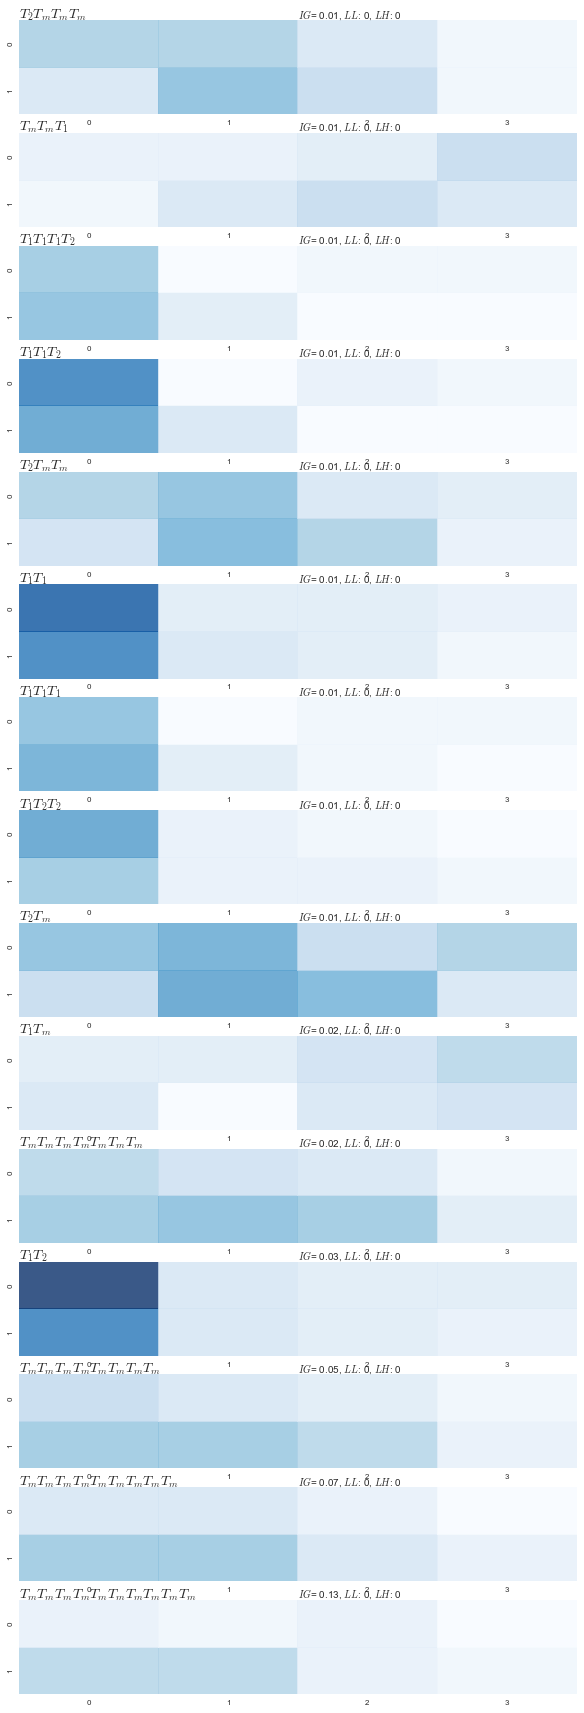

In [9]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops)[0]
fig, axes = plt.subplots(len(tops),1)#, sharex=True, sharey=True)
maximum = int(max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs]))
for i,(seq,ig) in enumerate(tops):
    ax = axes[i]
    data = sequence_counts_both[seq]
    ax = axes[i]
    hl,ll = 0,0
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,2.05, seq, fontsize=14)
    ax.text(2.0,2.05, "$IG$= {0}, $LL$: {1}, $LH$: {2}".format(str(round(ig,2)),ll,hl), fontsize=10)
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=False) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,30)
    ax.set_frame_on(False)
    i += 1

### We run the info gain analysis on blocks of testing sequences
$CPT_1PT_1T_2$ becomes $T_1T_2$

In [22]:
students = get_students(attribute='split pre',level='low')
CUT_OFF = 0.1 #we keep only sequences used once by at least 10% of students
shortest_seq_length = 2
longest_seq_length = 10

### PARAMETERS
attribute = 'split post t2'
level1 = 'high'
level2 = 'low'
family_category = "Family"
axis = 1

BINS = 1
sequence_counts_group = get_sequence_use_by_timebin(df,students,family_category,
                                          1,attribute,level1,level2,
                                          shortest_seq_length,longest_seq_length,CUT_OFF,ignore = ['I','C','P','To'])
tops = get_top_seqs(rank_sequences(sequence_counts_group,BINS,axis),15)

BINS = 4
sequence_counts_both = get_sequence_use_by_timebin(df,students,family_category,
                                  BINS,attribute,level1,level2,
                                  shortest_seq_length,longest_seq_length,CUT_OFF,ignore = ['I','C','P','To'])


Getting sequence use over 1 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 10% of students 
    in each group and overall.
Getting sequence use over 4 time bins for 74 students split by split post t2. 
    Keeping only sequences used once by at least 10% of students 
    in each group and overall.


Here are the sequences and how they were used by LH and LL

In [23]:
sequence_counts_group

{'TbTc': array([[ 14.],
        [ 10.]]), 'TbTcTb': array([[ 8.],
        [ 4.]]), 'TbTcTbTc': array([[ 7.],
        [ 3.]]), 'TbTcTs': array([[ 5.],
        [ 4.]]), 'TbTcTsTc': array([[ 3.],
        [ 3.]]), 'TbTcTsTcTs': array([[ 0.],
        [ 3.]]), 'TbTs': array([[ 25.],
        [ 17.]]), 'TbTsTb': array([[ 3.],
        [ 5.]]), 'TbTsTbTs': array([[ 2.],
        [ 4.]]), 'TbTsTbTsTb': array([[ 0.],
        [ 2.]]), 'TbTsTbTsTbTs': array([[ 0.],
        [ 2.]]), 'TbTsTbTsTbTsTc': array([[ 0.],
        [ 2.]]), 'TbTsTbTsTc': array([[ 2.],
        [ 4.]]), 'TbTsTbTsTcTb': array([[ 1.],
        [ 2.]]), 'TbTsTbTsTcTs': array([[ 1.],
        [ 3.]]), 'TbTsTc': array([[ 23.],
        [ 15.]]), 'TbTsTcTb': array([[ 9.],
        [ 7.]]), 'TbTsTcTbTc': array([[ 4.],
        [ 3.]]), 'TbTsTcTbTcTb': array([[ 4.],
        [ 1.]]), 'TbTsTcTbTcTbTc': array([[ 4.],
        [ 1.]]), 'TbTsTcTbTs': array([[ 3.],
        [ 4.]]), 'TbTsTcTbTsTc': array([[ 3.],
        [ 3.]]), 'TbTsTcTs': array([[ 

Here are the sequences and how they were used by LH and LL over time

In [12]:
sequence_counts_both

{'TbTc': array([[ 6.,  3.,  5.,  6.],
        [ 4.,  1.,  2.,  7.]]), 'TbTs': array([[ 24.,   3.,   3.,   3.],
        [ 17.,   3.,   1.,   3.]]), 'TbTsTc': array([[ 21.,   3.,   3.,   2.],
        [ 14.,   3.,   0.,   2.]]), 'TcTb': array([[ 7.,  3.,  6.,  3.],
        [ 8.,  4.,  3.,  3.]]), 'TcTs': array([[ 13.,   3.,   3.,   2.],
        [  8.,   5.,   5.,   5.]]), 'TsTc': array([[ 21.,   6.,   6.,   4.],
        [ 16.,   6.,   6.,   5.]]), 'TsTcTs': array([[ 10.,   1.,   3.,   1.],
        [  7.,   4.,   6.,   2.]])}

In [13]:
tops

[('TcTb', 0.00085789600809116351),
 ('TsTcTs', 0.0013640358414281906),
 ('TcTs', 0.0032083680183634389),
 ('TsTc', 0.0123074911041966),
 ('TbTc', 0.020131243348847194),
 ('TbTs', 0.026331935450379929),
 ('TbTsTc', 0.032211537173232108)]

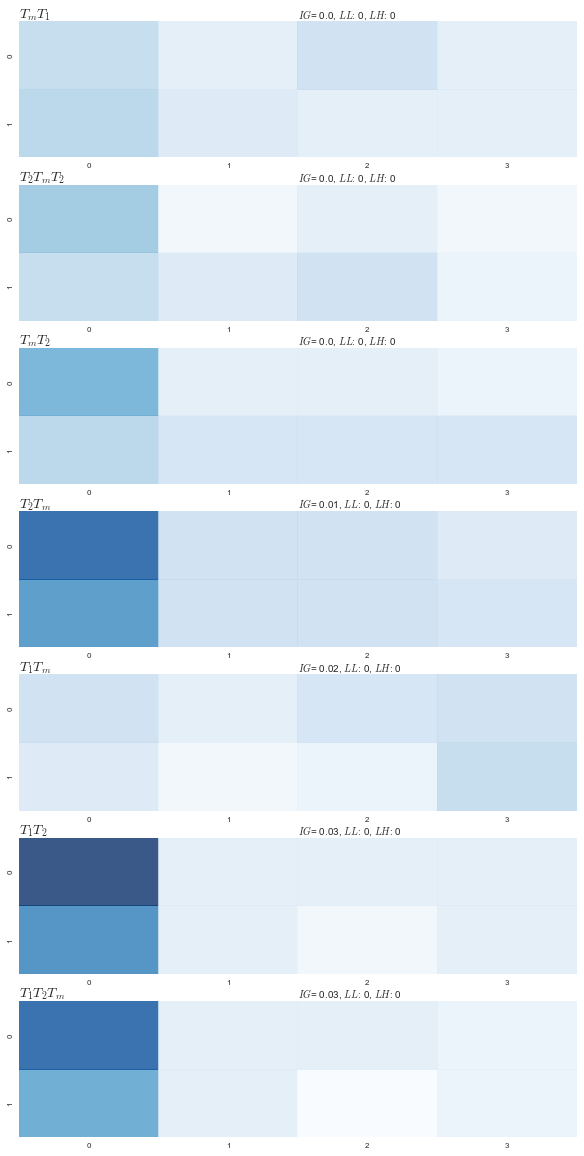

In [14]:
sns.set_style("darkgrid")
sns.set_context("paper")
all_seqs = zip(*tops)[0]
fig, axes = plt.subplots(len(tops),1)#, sharex=True, sharey=True)
maximum = int(max([np.amax(counts) for seq,counts in sequence_counts_both.iteritems() if seq in all_seqs]))
for i,(seq,ig) in enumerate(tops):
    ax = axes[i]
    data = sequence_counts_both[seq]
    ax = axes[i]
    hl,ll = 0,0
    seq = "$"+seq.replace('Ts','T_2').replace('Tb','T_1').replace('Tc','T_m')+"$"
    ax.text(0,2.05, seq, fontsize=14)
    ax.text(2.0,2.05, "$IG$= {0}, $LL$: {1}, $LH$: {2}".format(str(round(ig,2)),ll,hl), fontsize=10)
    heatmap = sns.heatmap(data, ax=ax, cmap=plt.cm.Blues,alpha=0.8, vmin=0, vmax=maximum, cbar=False,
                          annot=False) #, annot_kws={'fontweight':'bold'})
    fig.set_size_inches(10,20)
    ax.set_frame_on(False)
    i += 1

## Look at pairs of testing blocks
Let's get an idea of the sequence lengths if we only look at testing blocks

length in blocks :
	T-test:	0.214 	 p=0.8308
	HL<LL:	715.0 	 p=0.6344
	HL>LL:	715.0 	 p=0.3697
	two-sided:	715.0 	 p=0.7394
5.31081081081 4.49602129117


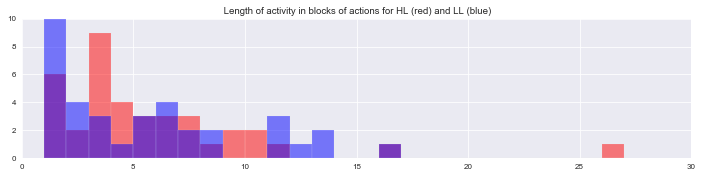

In [27]:
length_HL = [len(seq) for seq in blocks_HL.values()];length_LL = [len(seq) for seq in blocks_LL.values()]
fig, axs = plt.subplots(1,figsize=(12,2.5))
ymax= max(max(length_HL),max(length_LL))
bins = range(0,ymax+2,)
plt.hist(length_HL,color ='r',alpha = 0.5,bins = bins);plt.hist(length_LL,color = 'b',alpha = 0.5,bins = bins)
plt.title(" Length of activity in blocks of actions for HL (red) and LL (blue)")
perform_comparative_stats('length in blocks',length_HL,length_LL)
L = length_HL
L.extend(length_LL)
print np.mean(L), np.std(L)

So most people have sequences under 5 blocks so it doesn't make sense to compare frequencies. Let's compare how many students of each group use each pair.

In [45]:
students_Lpre = set(get_students('split pre','low'));H_post = set(get_students('split post t2','high'));L_post = set(get_students('split post t2','low'))
students_HL = H_post.intersection(students_Lpre)
students_LL = L_post.intersection(students_Lpre)
blocks_HL, _ =  get_blocks_withTime_new(df,students_HL,"Family",start=False,ignore=['I','C','P','To'], as_list=True)
blocks_LL, _ =  get_blocks_withTime_new(df,students_LL,"Family",start=False,ignore=['I','C','P','To'], as_list=True)

paired_seqs = ['TbTs','TbTc','TsTc','TsTb','TcTb','TcTs']
for seq in paired_seqs:
    print seq
    run_chi2(seq,blocks_HL,blocks_LL)

TbTs
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        25        17       42
didn't use it  13        19       32
total          38        36       74
-------------  --------  -------  -----
old:  Power_divergenceResult(statistic=1.1228766360345301, pvalue=0.28929988196266532)
new: (2.596652220829851, 0.10708971102135106, 1L, array([[ 21.57,  20.43],
       [ 16.43,  15.57]]))
TbTc
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        14        10       24
didn't use it  24        26       50
total          38        36       74
-------------  --------  -------  -----
old:  Power_divergenceResult(statistic=0.46832358674463925, pvalue=0.49375940959644182)
new: (0.69311890838206658, 0.40510554607107374, 1L, array([[ 12.32,  11.68],
       [ 25.68,  24.32]]))
TsTc
-------------  --------  -------  -----
               Low-High  Low-Low  total
used it        26        20       46
didn't use it  12        

There's nothing here! Clearly the order in which you test doesn't really matter. It's the deliberateness and reflectin that matters